Evaluates a RPN model which is trained using 100 gaussian noise perturbed samples (std_dev=0.2) for each sample, forcing all of them to predict the same label or same type of dirichlet distribution. This is a smoothed classifier with random noise => Randomly smoothed PN => Robust PN.

In [1]:
import sys
import os
sys.path.append('/nfs/homedirs/giri/masterthesis')
os.chdir('/nfs/homedirs/giri/masterthesis')

In [2]:
import torch
import os
from sklearn.metrics import precision_recall_curve,auc,roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
from pylab import rcParams
from PIL import Image
from IPython.display import display
from robust_priornet.eval.uncertainty import UncertaintyMeasuresEnum
from robust_priornet.utils.visualizer import plot_adv_samples,plot_all_roc_curves, plot_all_pr_curves, plot_adv_samples_ood
from robust_priornet.attack_priornet import plot_ood_attack_success
from robust_priornet.training.adversarial_trainer import get_optimal_threshold

In [3]:
model_dir="runtime-model-vgg6-5epochs-rpn-simple-10"
batch_size=64
n_in=28
num_channels=1
data_dir="./runtime-data"
in_dataset="MNIST"
ood_dataset="OMNIGLOT"

### Utils

In [4]:
def display_pr_roc_curves(model_dir, eval_dir, uncertainty_measure: UncertaintyMeasuresEnum):
    #figure, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,20))
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_PR_Curve.png'))
    display(img)
    img = Image.open(os.path.join(model_dir, eval_dir, f'{uncertainty_measure._value_}_ROC_Curve.png'))
    display(img)

In [5]:
def create_vis_plots(org_eval_dir, attack_dir, epsilon, plots_dir='vis', misclassified_indices=[], limit=None):
    # all images are saved in 'vis' directory under attack folder
    misclassified_samples = plot_adv_samples(org_eval_dir, attack_dir, epsilon, plots_dir, misclassified_indices, limit=limit)

    last_batch = misclassified_samples - (misclassified_samples%10) if limit is None else (limit-10)
    display(Image.open(f"{attack_dir}/e{epsilon}-attack/{plots_dir}/result_vis_{last_batch}.png")) # prints the last but one batch

## Model Evaluation

### Misclassify detect task (only In domain dataset) evaluation (CPU)
#### For GPU eval, use seml script eval_seml.py

In [12]:
out_dir=model_dir+"/eval"

In [13]:
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --model_dir {model_dir} --result_dir {out_dir} --task misclassification_detect --batch_size {batch_size} {data_dir} {in_dataset} OMNIGLOT"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --model_dir runtime-model-vgg6-5epochs-rpn-simple-10 --result_dir runtime-model-vgg6-5epochs-rpn-simple-10/eval --task misclassification_detect --batch_size 64 ./runtime-data MNIST OMNIGLOT


In [14]:
os.system(cmd)

0

#### Evaluation results - CONFIDENCE

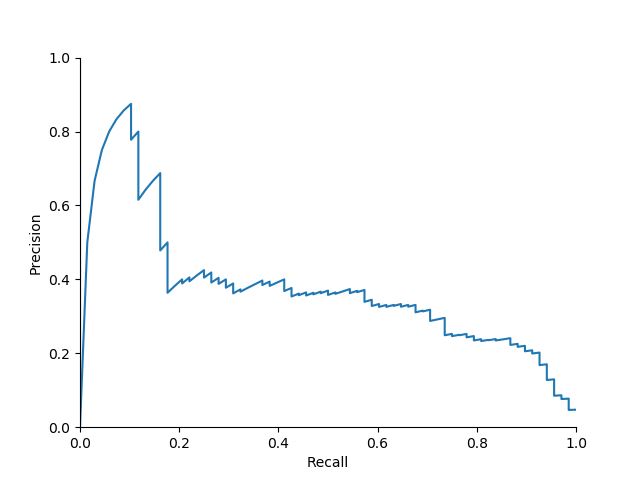

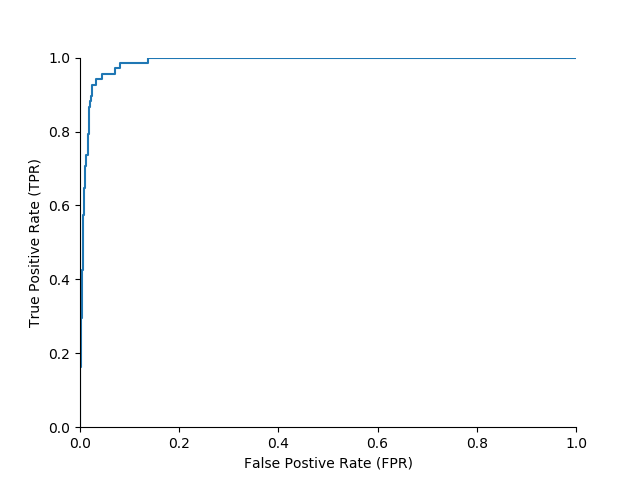

In [6]:
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE)

#### Evaluation results - overall

In [7]:
# Model's evaluation results for misclassification task
with open(f'{model_dir}/eval/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.7 
NLL: 4.058000087738037 
AUPR using confidence: 37.4
AUROC using confidence: 98.8
AUPR using total_uncertainty: 34.5
AUROC using total_uncertainty: 98.6
AUPR using expected_data_uncertainty: 35.0
AUROC using expected_data_uncertainty: 98.6
AUPR using distributional_uncertainty: 26.5
AUROC using distributional_uncertainty: 98.3
AUPR using differential_entropy: 32.2
AUROC using differential_entropy: 98.0



### OOD Detect task (Both In-domain and OOD dataset) evaluation (CPU)
#### For GPU eval, use seml script eval_seml.py

In [18]:
ood_dataset="OMNIGLOT"
out_dir=model_dir+"/ood-eval-omniglot"

In [19]:
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --model_dir runtime-model-vgg6-5epochs-rpn-simple-10 --result_dir runtime-model-vgg6-5epochs-rpn-simple-10/ood-eval-omniglot ./runtime-data MNIST OMNIGLOT


In [20]:
os.system(cmd)

0

#### Evaluation results - CONFIDENCE

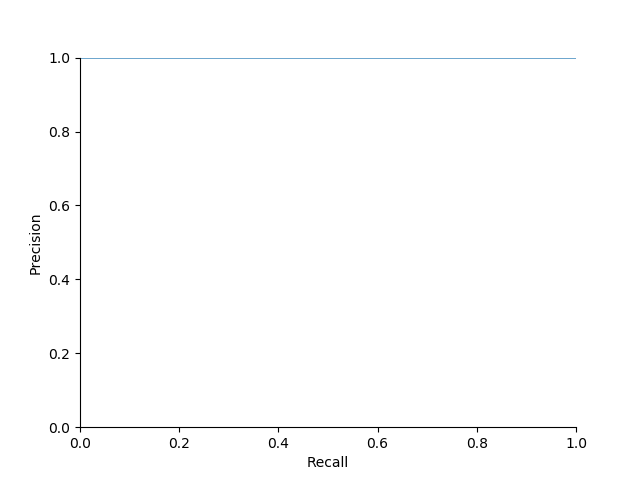

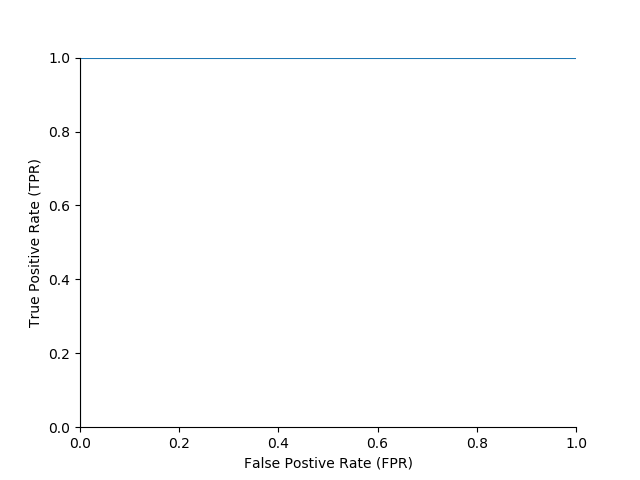

In [11]:
display_pr_roc_curves(model_dir, 'ood-eval-omniglot', UncertaintyMeasuresEnum.CONFIDENCE)

#### Evaluation results - overall

In [10]:
# VGG6 Model's evaluation results for ood detect task - against OMNIGLOT (ood dataset used in training)
with open(f'{model_dir}/ood-eval-omniglot/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.7 
NLL: 4.057000160217285 
AUPR using confidence: 100.0
AUROC using confidence: 100.0
AUPR using total_uncertainty: 100.0
AUROC using total_uncertainty: 100.0
AUPR using expected_data_uncertainty: 100.0
AUROC using expected_data_uncertainty: 100.0
AUPR using distributional_uncertainty: 96.6
AUROC using distributional_uncertainty: 99.7
AUPR using differential_entropy: 100.0
AUROC using differential_entropy: 100.0



In [8]:
# VGG6 Model's evaluation results for ood detect task - against CIFAR10 (ood dataset not seen during training)
with open(f'{model_dir}/ood-eval-cifar10/results.txt', 'r') as f:
    print(f.read())

Classification Error: 0.7 
NLL: 4.058000087738037 
AUPR using confidence: 100.0
AUROC using confidence: 100.0
AUPR using total_uncertainty: 100.0
AUROC using total_uncertainty: 100.0
AUPR using expected_data_uncertainty: 100.0
AUROC using expected_data_uncertainty: 100.0
AUPR using distributional_uncertainty: 99.0
AUROC using distributional_uncertainty: 99.7
AUPR using differential_entropy: 100.0
AUROC using differential_entropy: 100.0



## Estimating thresholds of Uncertainty Measures for ood-detect attacks

### MNIST + OMNIGLOT (valset)

In [4]:
ood_dataset = "OMNIGLOT"
out_dir=model_dir+"/ood-eval-val"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --val_dataset --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --val_dataset --model_dir runtime-model-vgg6-5epochs-rpn-simple-10 --result_dir runtime-model-vgg6-5epochs-rpn-simple-10/ood-eval-val ./runtime-data MNIST OMNIGLOT


In [5]:
os.system(cmd)

0

In [6]:
np.round(get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY),4)

Max fn value:  1.0
Threshold: -12.863973617553711, TPR: 1.0, FPR: 0.0


-12.864

In [7]:
np.round(get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY),4)

Max fn value:  0.9958333333333333
Threshold: 0.3711167573928833, TPR: 1.0, FPR: 0.004166666666666667


0.3711

In [8]:
np.round(get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.CONFIDENCE),4)
# note that threshold value has decreased comparison to normal model - (-0.37283)
# so now ood-samples from OMNIGLOT will have confidence below 0.11 to be correctly classified, whereas earlier it was 0.37
# so adv training on OMNIGLOT adv, has shifted the threshold

Max fn value:  1.0
Threshold: -0.11768762022256851, TPR: 1.0, FPR: 0.0


-0.1177

### MNIST + CIFAR10 (valset) - NOT USED

In [32]:
ood_dataset = "CIFAR10"
out_dir=model_dir+"/ood-eval-val-cifar10"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --val_dataset --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --val_dataset --model_dir runtime-model-vgg6-50epochs-adgen-robust-conf --result_dir runtime-model-vgg6-50epochs-adgen-robust-conf/ood-eval-val-cifar10 ./runtime-data MNIST CIFAR10


In [33]:
os.system(cmd)

0

In [34]:
get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY)

Max fn value:  0.9923333333333333
Threshold: -19.081802368164062, TPR: 0.996, FPR: 0.0036666666666666666


-19.081802368164062

In [35]:
get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.DISTRIBUTIONAL_UNCERTAINTY)

Max fn value:  0.9821666666666666
Threshold: 0.1658341884613037, TPR: 0.994, FPR: 0.011833333333333333


0.1658341884613037

In [36]:
get_optimal_threshold(out_dir, UncertaintyMeasuresEnum.CONFIDENCE)
# note that threshold value has increased comparison to normal model - (-0.37283)
# so adv training on OMNIGLOT adv, has shifted the threshold for CIFAR10 away

Max fn value:  0.9881666666666666
Threshold: -0.6334209442138672, TPR: 0.998, FPR: 0.009833333333333333


-0.6334209442138672

## PGD Attack on confidence (test set) - misclassification eval

In [16]:
epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

In [17]:
out_dir = model_dir+"/attack-fgsm"
cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria confidence --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria confidence --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs-robust ./runtime-data MNIST runtime-model-vgg6-50epochs-robust/attack-fgsm


In [22]:
os.system(cmd)

0

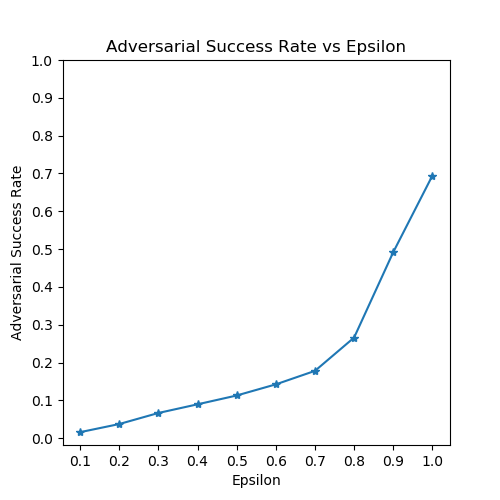

In [23]:
# sample epsilon curve
img = Image.open(os.path.join(model_dir, "attack-fgsm", "epsilon-curve.png"))
display(img)

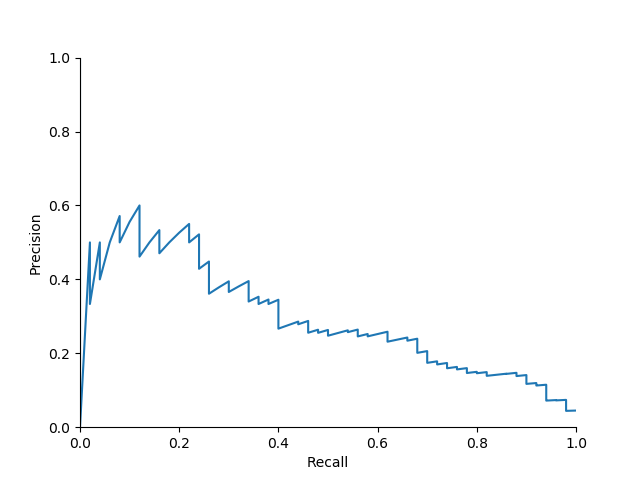

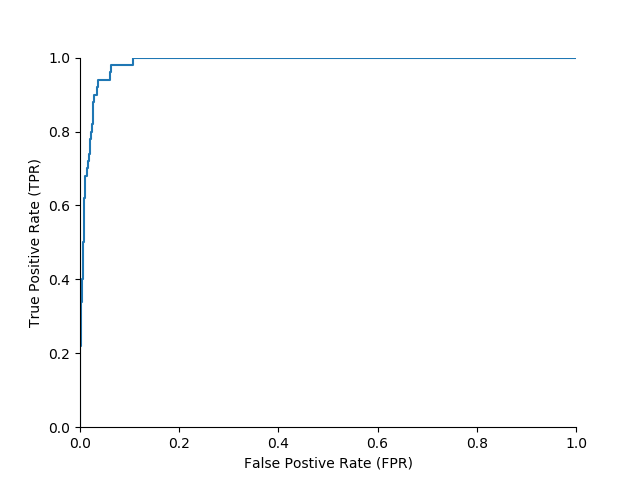

In [24]:
# model before attack
display_pr_roc_curves(model_dir, 'eval', UncertaintyMeasuresEnum.CONFIDENCE)

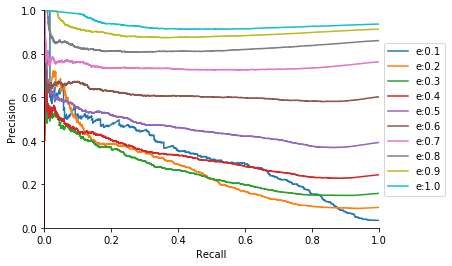

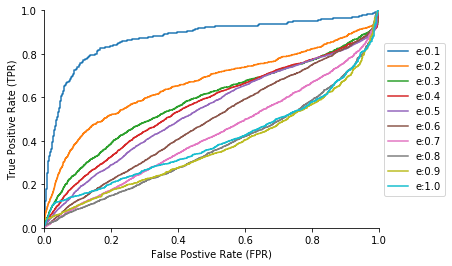

In [29]:
# model under attack (without adv training)
measure = UncertaintyMeasuresEnum.CONFIDENCE
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm', f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm', f"{measure._value_}_ROC_summary.png")))

In [27]:
# model under attack (after adv training)
attack_dir=os.path.join(model_dir, "attack-fgsm")
measure = UncertaintyMeasuresEnum.CONFIDENCE
plot_all_roc_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'eval', measure, attack_dir)

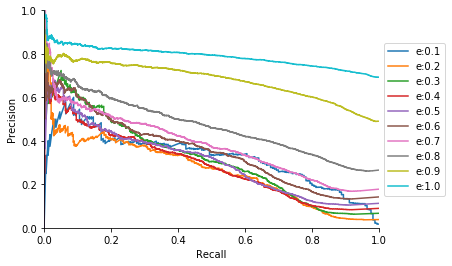

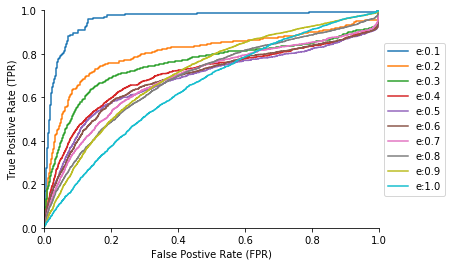

In [28]:
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

# Misclassified samples under attack:  1126
# Correct classified samples prior attack:  9950
# Real adversarial samples under attack:  1122


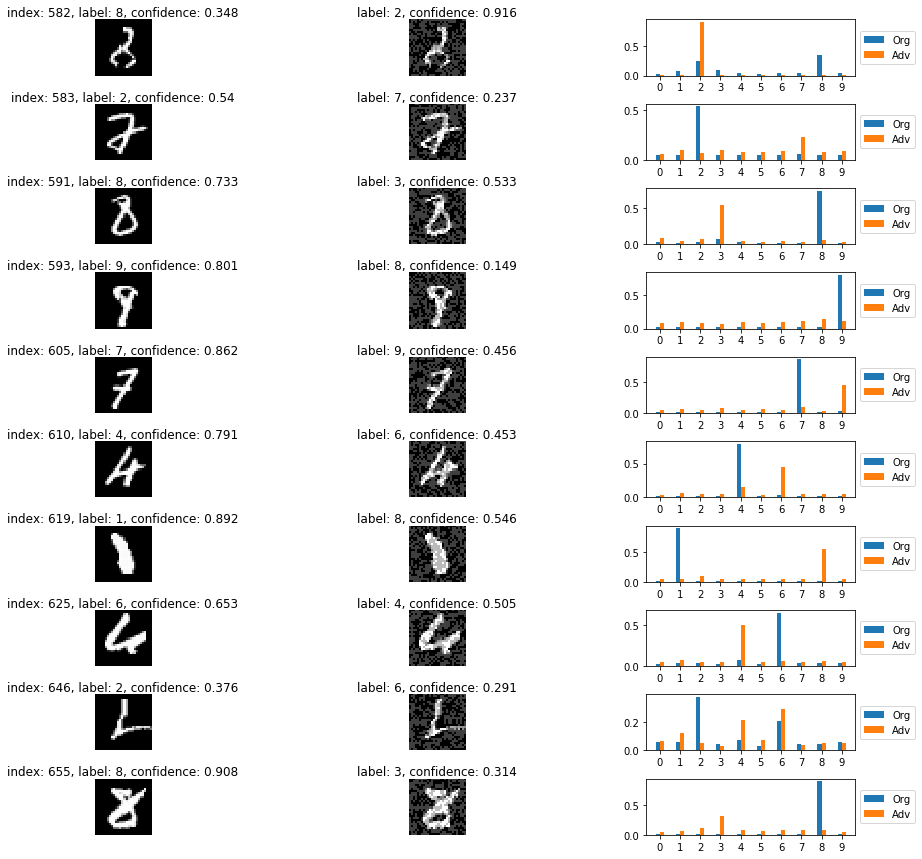

In [30]:
# some adversarial samples
attack_dir=os.path.join(model_dir, "attack-fgsm")
org_eval_dir=os.path.join(model_dir, "eval")
create_vis_plots(org_eval_dir, attack_dir, 0.5, limit=100)

## FGSM attack on confidence (trainset MNIST + SVHN) - ood detect eval

### Eval task on train set (only 5000 images)

In [10]:
out_dir=model_dir+"/ood-eval-train-svhn"
cmd = f"python -m robust_priornet.eval_priornet --gpu -1 --batch_size {batch_size} --task ood_detect --train_dataset --dataset_size_limit 5000 --model_dir {model_dir} --result_dir {out_dir} {data_dir} {in_dataset} {ood_dataset}"
print(cmd)

python -m robust_priornet.eval_priornet --gpu -1 --batch_size 64 --task ood_detect --train_dataset --dataset_size_limit 5000 --model_dir runtime-model-vgg6-50epochs-robust --result_dir runtime-model-vgg6-50epochs-robust/ood-eval-train-svhn ./runtime-data MNIST SVHN


In [ ]:
os.system(cmd)

### Attack

In [6]:
out_dir=model_dir+"/attack-fgsm-train-ood-svhn-conf"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria confidence --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria confidence --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset SVHN --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs-robust ./runtime-data MNIST runtime-model-vgg6-50epochs-robust/attack-fgsm-train-ood-svhn-conf


In [8]:
os.system(cmd)

0

#### Attack's epsilon curve - confidence

In [7]:
thresholds = [-0.5497,-0.3537,-0.2148,-0.1679,-0.1496,-0.1413,-0.1363,-0.1343,-0.1328,-0.1322]

In [8]:
result_dir = os.path.join(out_dir, 'ood-success-confidence')
os.makedirs(result_dir)
id_success, ood_success = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.CONFIDENCE, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -0.5497
tn: 4910, fp: 90, fn: 710, tp: 4290, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: -0.3537
tn: 4867, fp: 133, fn: 1785, tp: 3215, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: -0.2148
tn: 4930, fp: 70, fn: 2051, tp: 2949, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: -0.1679
tn: 4966, fp: 34, fn: 2104, tp: 2896, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: -0.1496
tn: 4981, fp: 19, fn: 2057, tp: 2943, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: -0.1413
tn: 4982, fp: 18, fn: 1908, tp: 3092, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: -0.1363
tn: 4979, fp: 21, fn: 1734, tp: 3266, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: -0.1343
tn: 4926, fp: 74, fn: 1483, tp: 3517, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: -0.1328
tn: 4592, fp: 408, fn: 1302, tp: 3698, total_id: 5000, total_ood: 5000
epsilon: 1.0, threshold: -0.1322
tn: 3463, fp: 1537, fn: 1139, tp: 3861,

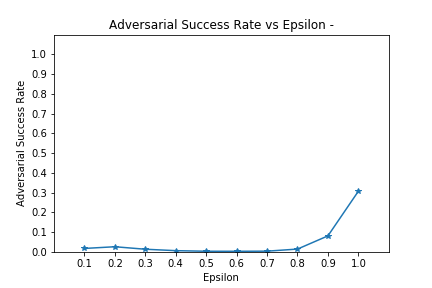

In [9]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-confidence', 'epsilon-curve_id.png')))

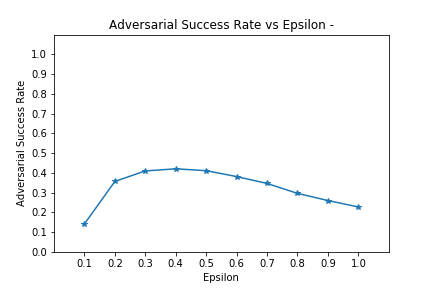

In [10]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-confidence', 'epsilon-curve_ood.png')))

#### PR, ROC curves before and after attack - confidence

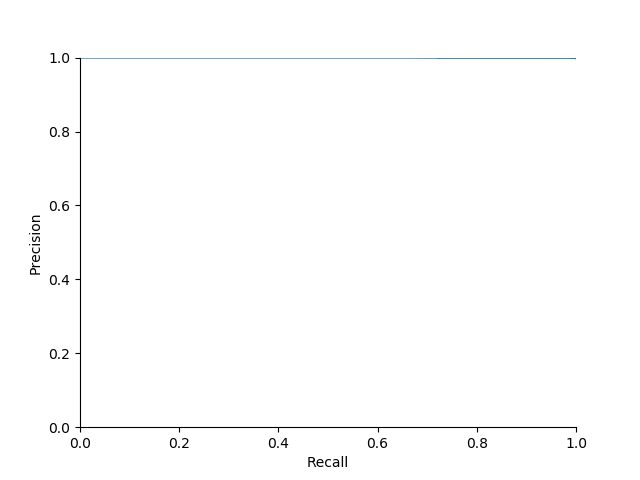

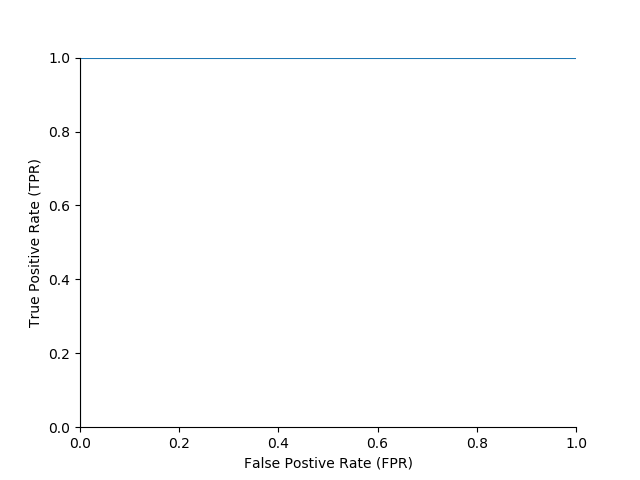

In [9]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-train-svhn', UncertaintyMeasuresEnum.CONFIDENCE)

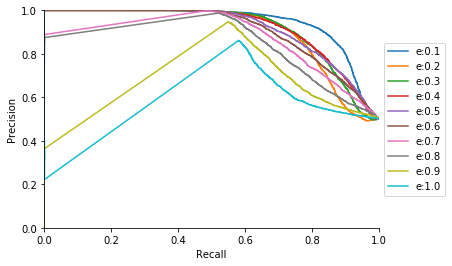

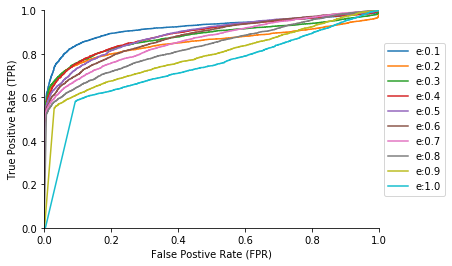

In [11]:
# model under attack - confidence (no adv training)
measure = UncertaintyMeasuresEnum.CONFIDENCE
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm-train-ood-conf-svhn', f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm-train-ood-conf-svhn', f"{measure._value_}_ROC_summary.png")))

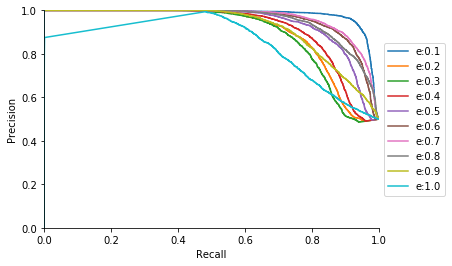

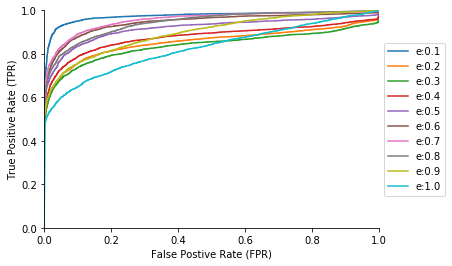

In [10]:
# model under attack - confidence (after adv training)
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-svhn-conf")
measure = UncertaintyMeasuresEnum.CONFIDENCE
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

#### Some sample adversarial samples

In [34]:
org_eval_dir = os.path.join(model_dir, 'ood-eval-train-svhn')
plot_adv_samples_ood(org_eval_dir, out_dir, 0.5, thresholds[4], UncertaintyMeasuresEnum.CONFIDENCE, plots_dir='vis_confidence', limit=100)

Cross check: fp: 19
Cross check: fn: 2057


2076

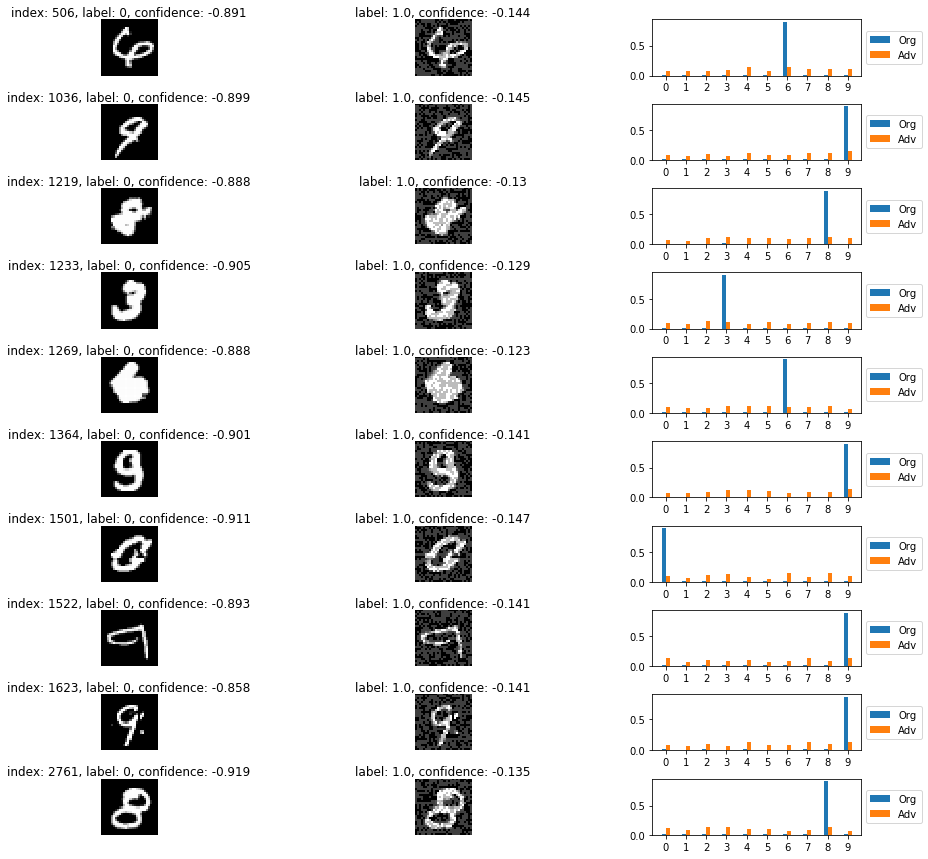

In [36]:
# in domain --> out domain (adversarial success for attacking in domain samples)
display(Image.open(os.path.join(out_dir, f'e0.5-attack', 'vis_confidence', 'in-out', 'result_vis_10.png')))

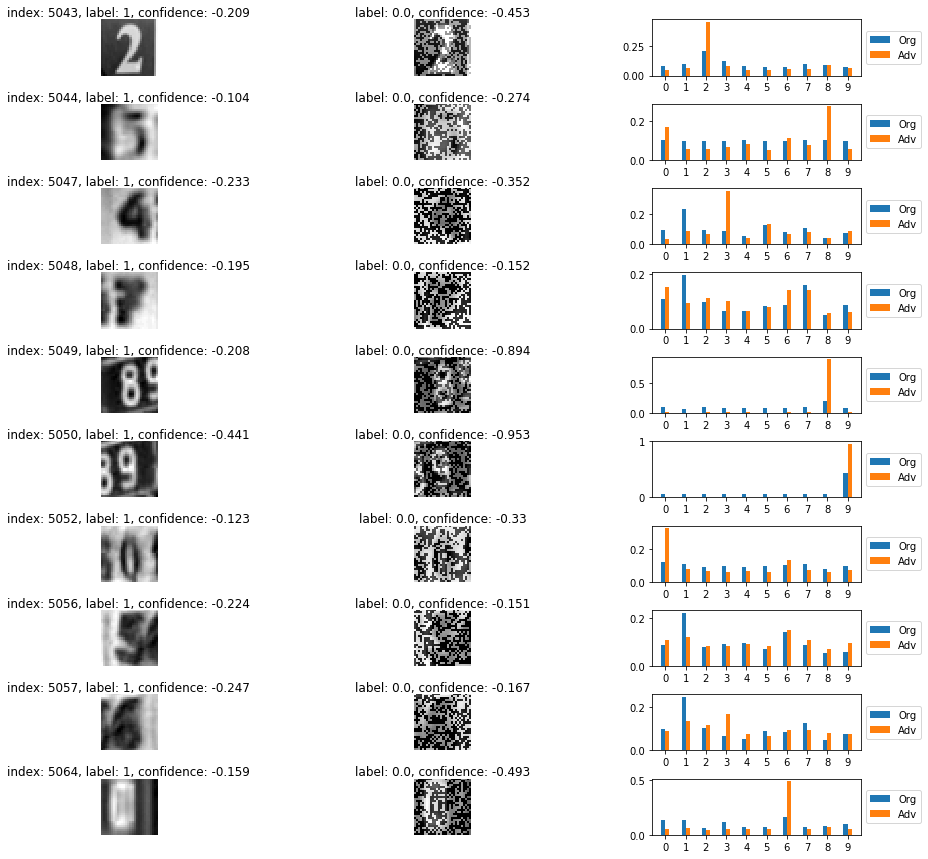

In [11]:
# out domain --> in domain (adversarial success for attacking out domain samples)
display(Image.open(os.path.join(out_dir, f'e0.5-attack', 'vis_confidence', 'out-in', 'result_vis_30.png')))

## FGSM attack on diff entropy (trainset MNIST + SVHN) - ood detect eval

In [39]:
out_dir=model_dir+"/attack-fgsm-train-ood-svhn-dentropy"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria diff_entropy --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria diff_entropy --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset SVHN --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs-robust ./runtime-data MNIST runtime-model-vgg6-50epochs-robust/attack-fgsm-train-ood-svhn-dentropy


In [13]:
os.system(cmd)

0

#### Attack's epsilon curve

In [43]:
thresholds = [-18.52049,-14.93081,-13.73132,-13.20055,-13.10584,-13.00481,-12.92809,-12.88405,-12.83937,-12.83091]

In [44]:
result_dir = os.path.join(out_dir, 'ood-success-dentropy')
os.makedirs(result_dir)
plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -18.52049
tn: 4935, fp: 65, fn: 618, tp: 4382, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: -14.93081
tn: 4949, fp: 51, fn: 2027, tp: 2973, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: -13.73132
tn: 4981, fp: 19, fn: 2330, tp: 2670, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: -13.20055
tn: 4996, fp: 4, fn: 2510, tp: 2490, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: -13.10584
tn: 4997, fp: 3, fn: 2358, tp: 2642, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: -13.00481
tn: 5000, fp: 0, fn: 2328, tp: 2672, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: -12.92809
tn: 4998, fp: 2, fn: 2313, tp: 2687, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: -12.88405
tn: 4997, fp: 3, fn: 2257, tp: 2743, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: -12.83937
tn: 4981, fp: 19, fn: 2298, tp: 2702, total_id: 5000, total_ood: 5000
epsilon: 1.0, threshold: -12.83091
tn: 4745, fp: 255, fn: 216

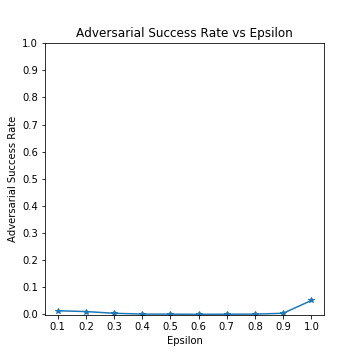

In [45]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_id.png')))

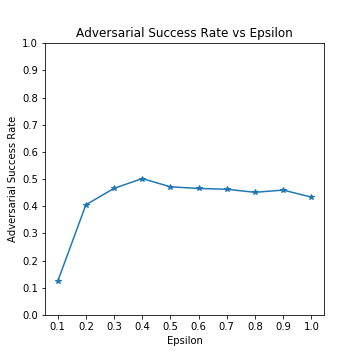

In [46]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_ood.png')))

#### PR, ROC curves before and after attack

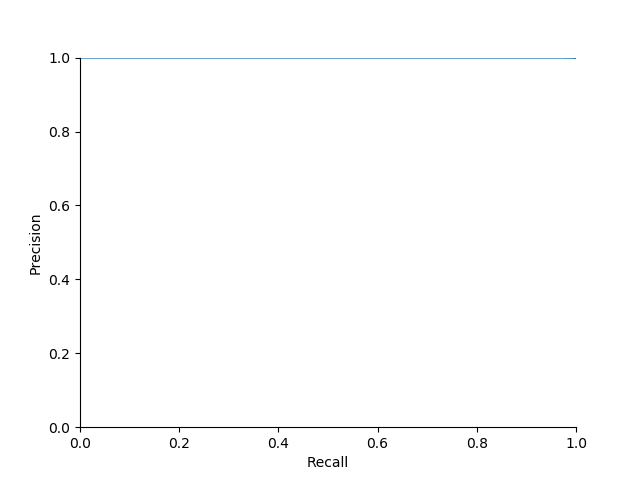

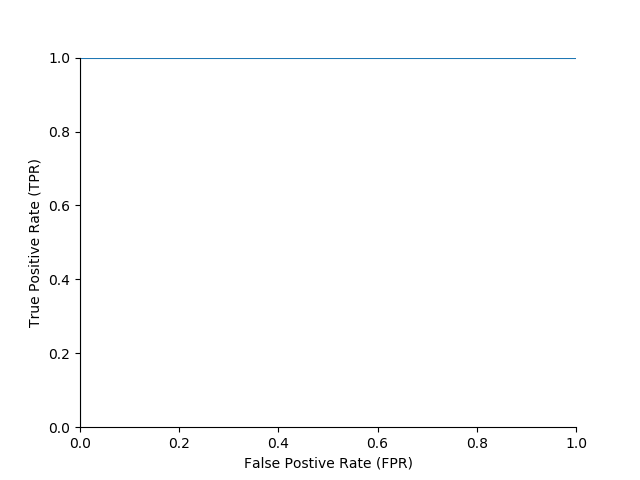

In [14]:
# model before attack
display_pr_roc_curves(model_dir, 'ood-eval-train-svhn', UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY)

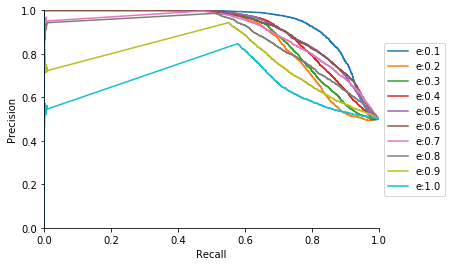

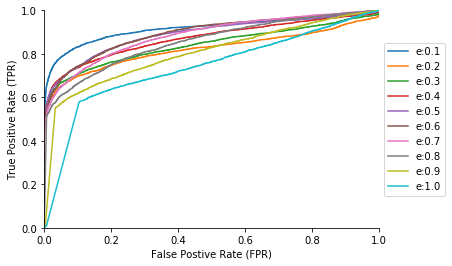

In [16]:
# model under attack - diff entropy (no adv training)
measure = UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm-train-ood-svhn', f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join('runtime-model-vgg6-50epochs', 'attack-fgsm-train-ood-svhn', f"{measure._value_}_ROC_summary.png")))

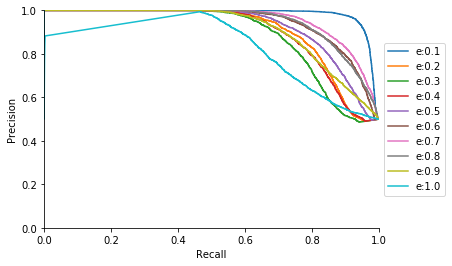

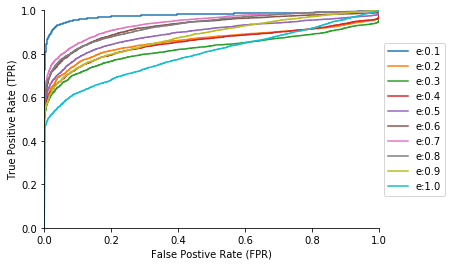

In [15]:
# model under attack - diff entropy (after adv training)
attack_dir=os.path.join(model_dir, "attack-fgsm-train-ood-svhn-dentropy")
measure = UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY
plot_all_roc_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)
plot_all_pr_curves(epsilon_list, attack_dir, 'ood_eval', measure, attack_dir)

display(Image.open(os.path.join(attack_dir, f"{measure._value_}_PR_summary.png")))
display(Image.open(os.path.join(attack_dir, f"{measure._value_}_ROC_summary.png")))

## FGSM attack on diff entropy (trainset MNIST + OMNIGLOT) - ood detect eval

In [12]:
ood_dataset = "OMNIGLOT"
out_dir=model_dir+"/attack-fgsm-train-ood-dentropy"

epsilon_list=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
epsilons = " ".join(map(lambda x: str(x),epsilon_list))

cmd = f"python -m robust_priornet.attack_priornet --gpu -1 --batch_size {batch_size} --attack_type FGSM --attack_criteria diff_entropy --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset {ood_dataset} --epsilon {epsilons} --model_dir {model_dir} {data_dir} {in_dataset} {out_dir}"
print(cmd)

python -m robust_priornet.attack_priornet --gpu -1 --batch_size 64 --attack_type FGSM --attack_criteria diff_entropy --train_dataset --dataset_size_limit 5000 --ood_eval --ood_dataset OMNIGLOT --epsilon 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0 --model_dir runtime-model-vgg6-50epochs-robust ./runtime-data MNIST runtime-model-vgg6-50epochs-robust/attack-fgsm-train-ood-dentropy


In [13]:
os.system(cmd)

0

#### Attack's epsilon curve

In [14]:
thresholds = [-18.52049,-14.93081,-13.73132,-13.20055,-13.10584,-13.00481,-12.92809,-12.88405,-12.83937,-12.83091]

In [15]:
result_dir = os.path.join(out_dir, 'ood-success-dentropy')
os.makedirs(result_dir)
id_success, ood_success = plot_ood_attack_success(epsilon_list, UncertaintyMeasuresEnum.DIFFERENTIAL_ENTROPY, thresholds, out_dir, result_dir)

epsilon: 0.1, threshold: -18.52049
tn: 4935, fp: 65, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.2, threshold: -14.93081
tn: 4949, fp: 51, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.3, threshold: -13.73132
tn: 4981, fp: 19, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.4, threshold: -13.20055
tn: 4996, fp: 4, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.5, threshold: -13.10584
tn: 4997, fp: 3, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.6, threshold: -13.00481
tn: 5000, fp: 0, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.7, threshold: -12.92809
tn: 4998, fp: 2, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.8, threshold: -12.88405
tn: 4997, fp: 3, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 0.9, threshold: -12.83937
tn: 4981, fp: 19, fn: 0, tp: 5000, total_id: 5000, total_ood: 5000
epsilon: 1.0, threshold: -12.83091
tn: 4745, fp: 255, fn: 0, tp: 5000, total_id: 5000, 

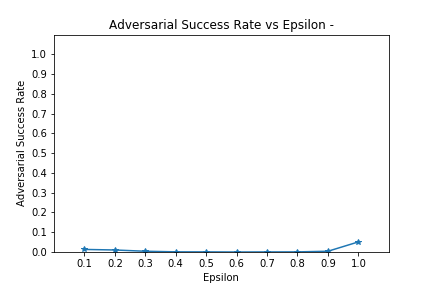

In [16]:
# Plotting in domain adversarial success, in domain sample falsly classified as out domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_id.png')))

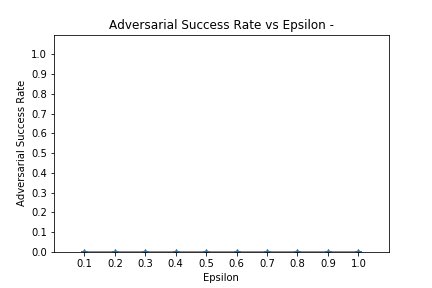

In [17]:
# Plotting out domain adversarial success, out domain sample falsly classified as in domain sample
display(Image.open(os.path.join(out_dir, 'ood-success-dentropy', 'epsilon-curve_ood.png')))